# 基于YOLO的目标检测算法

In [16]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import timedelta
from numpy import ndarray
from typing import Union, List, Dict
from sklearn.preprocessing import MinMaxScaler
import os
import cv2
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.patches as patches
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from ultralytics import YOLO
from tqdm import tqdm  # 打印进度条
import math
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import seaborn as sns
from typing import List
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import warnings

warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

## 基础知识

### 目标检测相关技术

目标检测（Object Detection）是一项计算机视觉任务，其目标是在图像或视频中识别并定位所有目标对象，同时对每个对象进行分类。以下是目标检测算法相关的基础知识和主要方法分类：

1、目标检测算法的主要任务  
- 分类：判断图片中是否存在目标对象。
- 定位：给出目标对象的边界框（Bounding Box）。
- 多目标检测：在一幅图片中检测多个目标并分类。

2、目标检测的主要方法  
目标检测算法可以分为两阶段方法和单阶段方法。

- 两阶段方法（Two-Stage Detectors）  
    这类方法先生成候选区域，然后对每个区域分类并回归边界框。代表性算法包括：  
    
    - R-CNN 系列  
    - R-CNN (Region-based CNN)：采用选择性搜索生成候选区域，逐一分类，效率较低。  
    - Fast R-CNN：引入ROI池化，提升了计算效率。  
    - Faster R-CNN：通过区域建议网络（RPN）生成候选框，大幅提高了速度。  
    - Mask R-CNN：在Faster R-CNN基础上增加分割分支，能完成实例分割任务。
- 单阶段方法（One-Stage Detectors）  
    这类方法直接回归边界框和分类，速度更快。代表性算法包括：  
    
    - YOLO 系列（You Only Look Once）
    - YOLOv1 ~ YOLOv8：每代模型提升精度、速度和推理能力。
    - SSD（Single Shot MultiBox Detector）：支持多尺度特征检测。
    - RetinaNet：引入Focal Loss，解决单阶段检测中正负样本比例失衡的问题。

3、目标检测的关键技术
- 特征提取
    - 卷积神经网络（CNN）：提取图像中的高级特征。
    - 骨干网络（Backbone）：
    - 经典网络：ResNet、VGG、MobileNet。
    - 专用网络：Darknet（用于YOLO）。
- 区域生成
    - 选择性搜索（Selective Search）：R-CNN使用。
    - 区域建议网络（RPN）：Faster R-CNN使用。
- 损失函数
    - 分类损失：交叉熵、Focal Loss。
    - 回归损失：Smooth L1 Loss、IoU Loss、GIoU、DIoU、CIoU。
- 多尺度特征融合
    - 特征金字塔网络（FPN）：利用金字塔结构融合不同层次的特征。
    - PANet：增强低层特征对检测的贡献。
- 数据增强
    - 旋转、缩放、翻转、颜色变换。
    - CutMix、Mosaic（YOLO系列常用）。
- 后处理
    - 非极大值抑制（NMS）：过滤冗余框。
    - Soft-NMS：对传统NMS改进，减少框误删。

### YOLO介绍

YOLO（You Only Look Once）是一种实时目标检测算法，由 Joseph Redmon 等人提出。它以其高效和准确的目标检测能力而闻名，广泛应用于计算机视觉任务中，如自动驾驶、安防监控和视频分析等领域。

**YOLO的主要特点**
- 单阶段检测：

    YOLO是一种单阶段检测算法，它直接从输入图像生成目标的类别和位置，无需像两阶段检测器（如R-CNN）那样生成候选区域并逐一分类。这样极大提高了检测速度。
- 全局考虑：

    YOLO将目标检测任务看作一个回归问题。它将整个图像一次性分成网格，每个网格预测固定数量的边界框及其所属类别。由于一次性处理整个图像，它对全局上下文信息的利用更充分。
- 实时性强：

    YOLO的检测速度非常快，适合实时应用。它的早期版本可以达到45 FPS（帧每秒），而后续优化版本（如Tiny YOLO）速度更快。
- 端到端训练：

    YOLO是一个端到端的深度学习模型，训练和推理过程紧密结合，易于优化。

**YOLO的工作原理**
- 输入处理：

    将输入图像调整为固定大小（如448x448），归一化处理。
- 网格划分：

    将图像分成固定的网格（如7x7）。  
    每个网格负责检测是否有目标及其边界框。
- 边界框预测：

    每个网格预测若干个边界框，并为每个框分配置信度分数（目标的概率和边界框的精确度）。
- 分类预测：

    每个边界框预测一个类别分数，用于确定目标的类别。
- 后处理：

    使用非极大值抑制（NMS）去除重复检测。

### 数据集构造

Ultralytics 是一个专注于计算机视觉的开源工具开发公司，以其高性能的目标检测框架 YOLOv5 和 YOLOv8 而闻名。它提供了高效的深度学习模型、API 和工具，适合快速开发、训练和部署计算机视觉任务。

Ultralytics推荐的数据集结构是这样的：

这里面是一个数据集文件夹，包含images、labels两个文件夹和一个data.yaml配置文件：

- images文件夹放图像，labels文件夹放标注文件，图像和标注文件的名称要一一对应
- images和labels文件夹下分别放train、val、test三个子文件夹，作为训练集、验证集和测试集
- data.yaml的格式如下：

标注文件的格式如下：

每一行的第一个数字代表标签\<class_id> ，后续的四个数字是标注框的\<x_center> \<y_center> \<width> \<height>相对于图像shape的**归一化值**（或者说比例）。  

- class_id: 类别编号，从 0 开始。
- x_center, y_center: 目标的中心点坐标，归一化到图片宽度和高度范围内。
- width, height: 目标框的宽度和高度，归一化到图片宽度和高度范围内。

标签文件中出现多行则代表着图像中有多个检测到的目标。

#### 坐标归一化

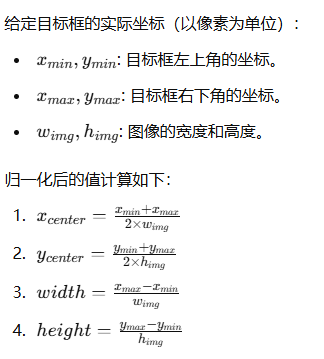

In [7]:
import os
import cv2  # 使用 OpenCV 读取图像

def get_image_size(image_path):
    """
    获取图像的宽度和高度
    :param image_path: 图像文件路径
    :return: (width, height)
    """
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"无法读取图像: {image_path}")
    height, width = image.shape[:2]
    return width, height

def convert_to_yolo_format(image_width, image_height, bbox):
    """
    将目标框转换为YOLO格式
    :param image_width: 图像宽度
    :param image_height: 图像高度
    :param bbox: 原始目标框 (x_min, y_min, x_max, y_max)
    :return: YOLO格式 (x_center, y_center, width, height)
    """
    x_min, y_min, x_max, y_max = bbox
    x_center = (x_min + x_max) / 2.0 / image_width
    y_center = (y_min + y_max) / 2.0 / image_height
    width = (x_max - x_min) / image_width
    height = (y_max - y_min) / image_height
    return x_center, y_center, width, height

def process_annotations(input_file, output_file, image_file):
    """
    处理原始标注文件并保存为YOLO格式
    :param input_file: 原始标注文件路径
    :param output_file: 输出YOLO格式文件路径
    :param image_file: 对应的图像文件路径
    """
    # 自动获取图像尺寸
    image_width, image_height = get_image_size(image_file)
    print(f"图像尺寸: 宽度={image_width}, 高度={image_height}")

    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            data = line.strip().split()
            class_id = data[0]
            bbox = list(map(float, data[1:5]))  # 假设原始文件中bbox格式为 (x_min, y_min, x_max, y_max)
            yolo_bbox = convert_to_yolo_format(image_width, image_height, bbox)
            yolo_line = f"{class_id} " + " ".join(f"{v:.6f}" for v in yolo_bbox)
            outfile.write(yolo_line + "\n")

# 示例使用
image_file = "../../../../../data/02.cv/dog-and-cat-detection/images/Cats_Test0.png"  # 输入图像文件
input_file = "../../../../../data/02.cv/dog-and-cat-detection/annotations_txt/Cats_Test0.txt"  # 原始标注文件
output_file = "../outputs/labels/yolo_annotations.txt"  # YOLO格式文件

process_annotations(input_file, output_file, image_file)

图像尺寸: 宽度=233, 高度=350


#### 坐标反归一化

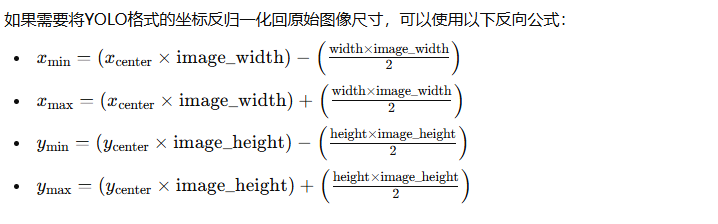

### 评估指标

#### IoU

Intersection over Union (IoU，交并比) 是评估目标检测模型性能的重要指标之一，用于衡量预测框和真实框之间的重叠程度。

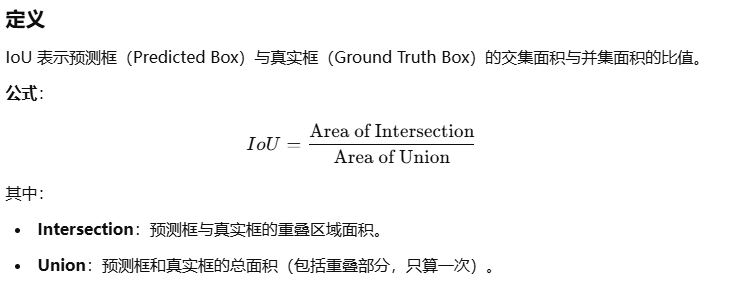
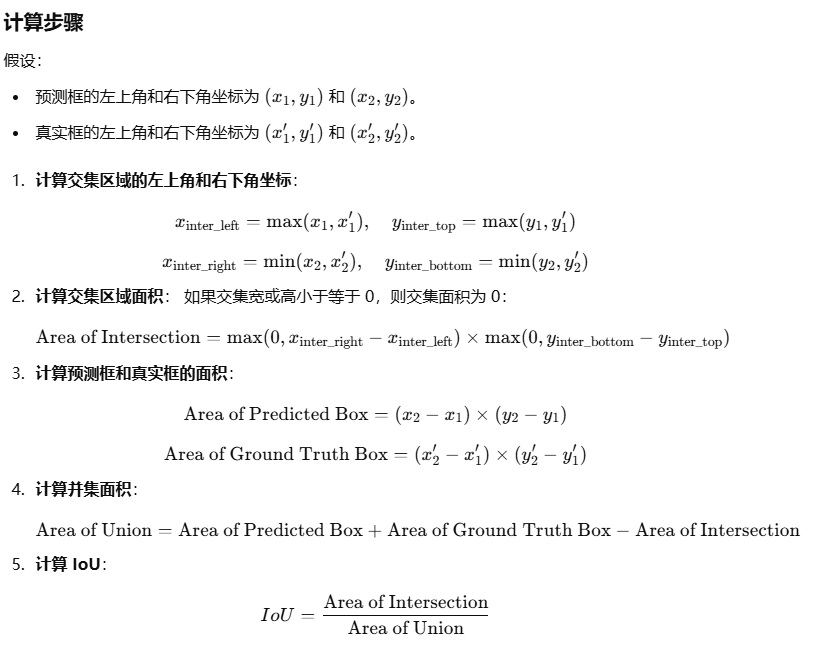
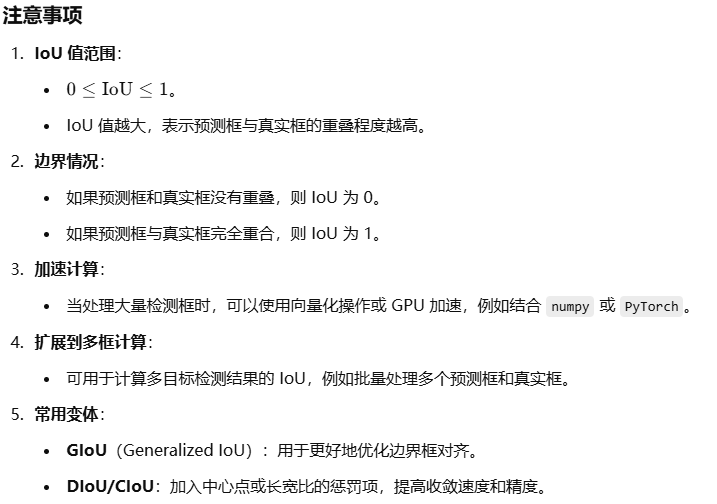

In [8]:
def calculate_iou(pred_box, gt_box):
    """
    计算预测框和真实框的 IoU 值。

    :param pred_box: 预测框坐标 (x1, y1, x2, y2)
    :param gt_box: 真实框坐标 (x1', y1', x2', y2')
    :return: IoU 值
    """
    # 解析坐标
    x1, y1, x2, y2 = pred_box
    x1_gt, y1_gt, x2_gt, y2_gt = gt_box

    # 计算交集坐标
    inter_left = max(x1, x1_gt)
    inter_top = max(y1, y1_gt)
    inter_right = min(x2, x2_gt)
    inter_bottom = min(y2, y2_gt)

    # 计算交集面积
    inter_width = max(0, inter_right - inter_left)
    inter_height = max(0, inter_bottom - inter_top)
    inter_area = inter_width * inter_height

    # 计算预测框和真实框面积
    pred_area = (x2 - x1) * (y2 - y1)
    gt_area = (x2_gt - x1_gt) * (y2_gt - y1_gt)

    # 计算并集面积
    union_area = pred_area + gt_area - inter_area

    # 计算 IoU
    iou = inter_area / union_area if union_area != 0 else 0
    return iou

# 示例
predicted_box = (50, 50, 150, 150)
ground_truth_box = (100, 100, 200, 200)

iou = calculate_iou(predicted_box, ground_truth_box)
print(f"IoU: {iou:.4f}")

IoU: 0.1429


#### AP（Average Precision，平均精度）

AP（Average Precision，平均精度） 是目标检测和图像分类等任务中常用的评估指标之一。它衡量了模型在某个类别上的检测质量，综合了**精确率（Precision）和召回率（Recall**）的表现。

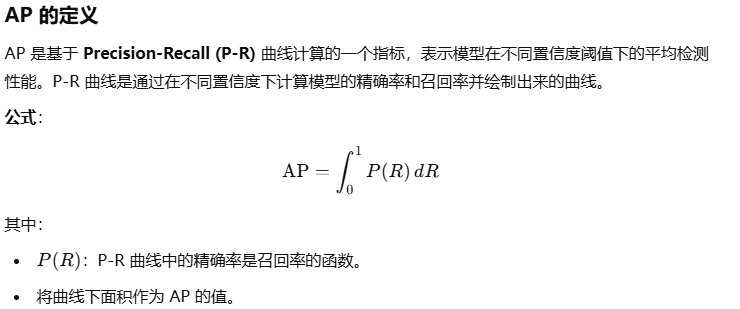
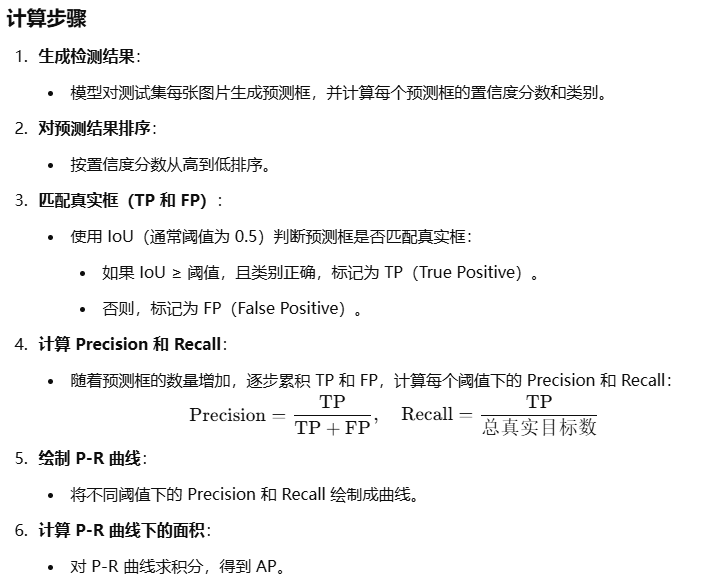

In [9]:
import numpy as np

def calculate_ap(recalls, precisions):
    """
    计算 AP 值
    :param recalls: 召回率数组
    :param precisions: 精确率数组
    :return: AP 值
    """
    # 在起点和终点补 0 和 1
    recalls = np.concatenate(([0.], recalls, [1.]))
    precisions = np.concatenate(([0.], precisions, [0.]))

    # 修正精确率，确保阶梯状性质
    for i in range(len(precisions) - 1, 0, -1):
        precisions[i - 1] = max(precisions[i - 1], precisions[i])

    # 计算面积
    indices = np.where(recalls[1:] != recalls[:-1])[0]
    ap = np.sum((recalls[indices + 1] - recalls[indices]) * precisions[indices + 1])
    return ap

# 示例数据
recalls = np.array([0.1, 0.4, 0.6, 0.8, 1.0])
precisions = np.array([1.0, 0.9, 0.7, 0.5, 0.3])

# 计算 AP
ap = calculate_ap(recalls, precisions)
print(f"AP: {ap:.4f}")

AP: 0.6700


#### mAP（Mean Average Precision）

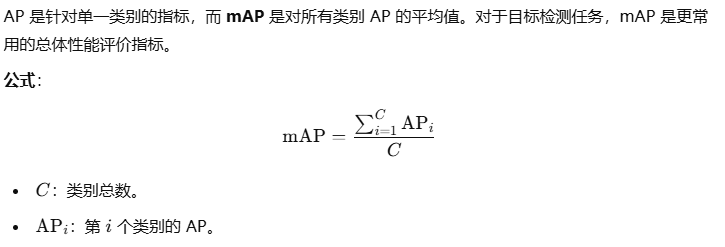

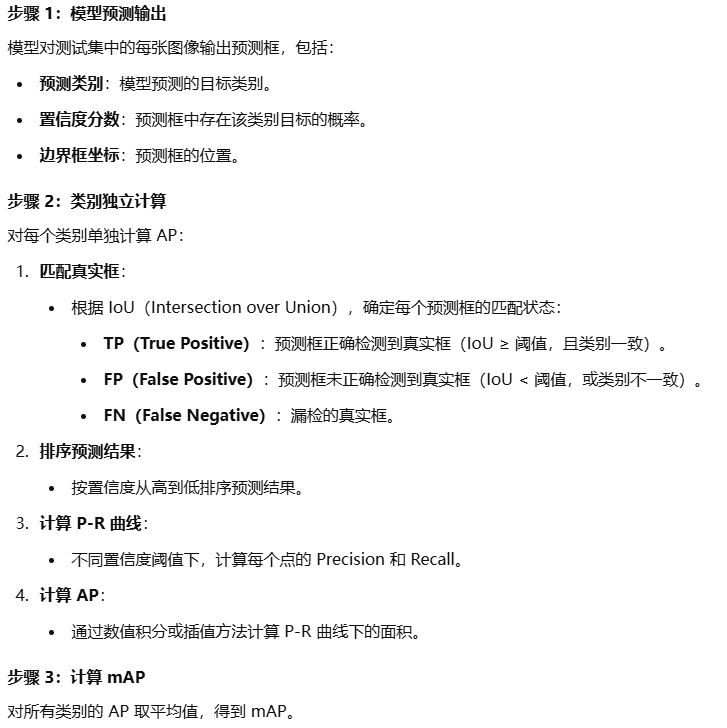

In [10]:
import numpy as np

def calculate_ap(recalls, precisions):
    """
    计算单个类别的 AP 值
    :param recalls: 召回率数组
    :param precisions: 精确率数组
    :return: AP 值
    """
    recalls = np.concatenate(([0.], recalls, [1.]))
    precisions = np.concatenate(([0.], precisions, [0.]))
    for i in range(len(precisions) - 1, 0, -1):
        precisions[i - 1] = max(precisions[i - 1], precisions[i])
    indices = np.where(recalls[1:] != recalls[:-1])[0]
    ap = np.sum((recalls[indices + 1] - recalls[indices]) * precisions[indices + 1])
    return ap

def calculate_map(aps):
    """
    计算 mAP
    :param aps: 所有类别的 AP 值列表
    :return: mAP 值
    """
    return np.mean(aps)

# 示例：3 个类别的 P-R 曲线数据
recalls_list = [
    [0.1, 0.4, 0.6, 0.8, 1.0],  # 类别 1
    [0.0, 0.2, 0.5, 0.7, 1.0],  # 类别 2
    [0.2, 0.5, 0.7, 0.9, 1.0]   # 类别 3
]
precisions_list = [
    [1.0, 0.9, 0.8, 0.6, 0.5],  # 类别 1
    [1.0, 0.8, 0.6, 0.5, 0.3],  # 类别 2
    [0.9, 0.7, 0.5, 0.4, 0.2]   # 类别 3
]

# 计算每个类别的 AP
aps = [calculate_ap(np.array(recalls), np.array(precisions))
       for recalls, precisions in zip(recalls_list, precisions_list)]

# 计算 mAP
map_value = calculate_map(aps)
print(f"mAP: {map_value:.4f}")

mAP: 0.6233


#### Box(P, R, mAP50, mAP50-95)

在目标检测任务中，Box(P, R, mAP50, mAP50-95) 是用于评估检测模型性能的重要指标。这些指标用于衡量模型在定位目标和分类目标方面的准确性，具体解释如下：

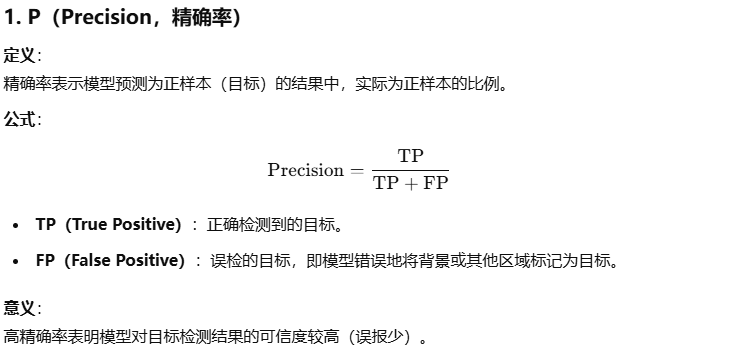
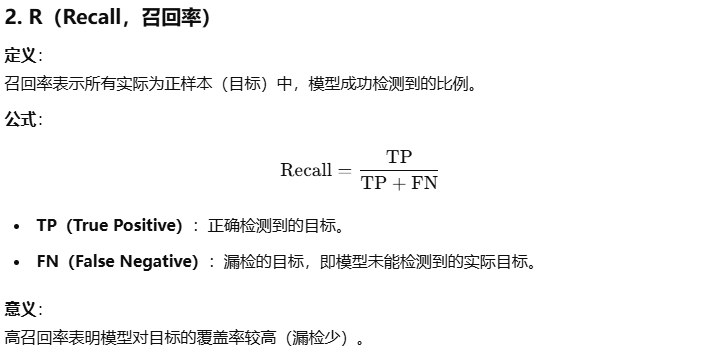
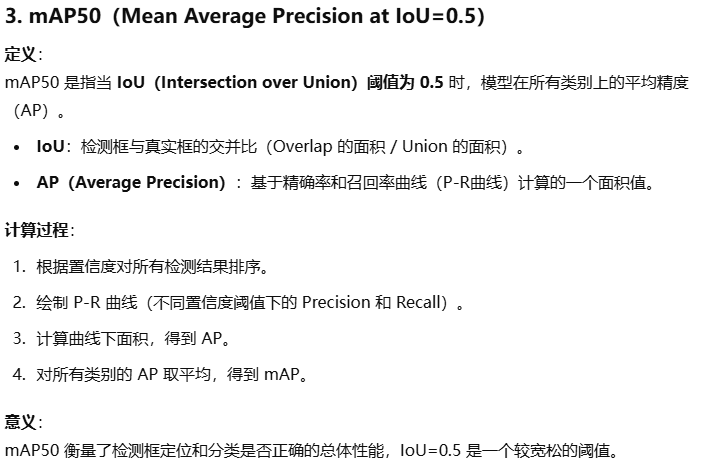
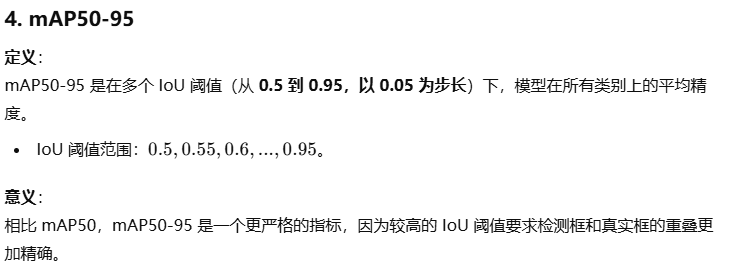

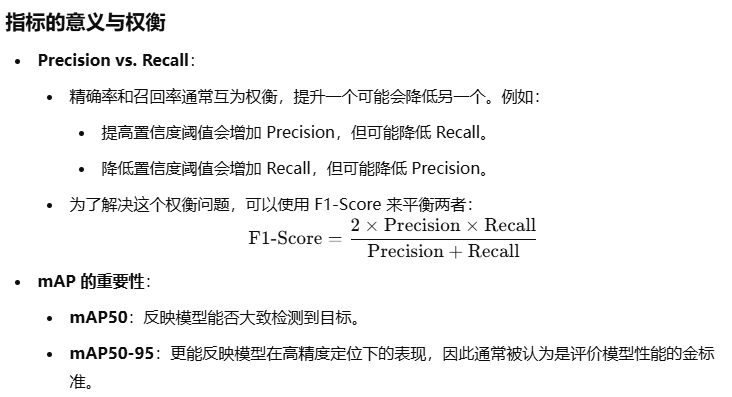

## 数据准备

### 公开数据集

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")

print("Path to dataset files:", path)

100%|█████████████████████████████████████████████████████████████████████████████| 1.03G/1.03G [10:15<00:00, 1.79MB/s]

Extracting model files...


Path to dataset files: C:\Users\caoyuyu\.cache\kagglehub\datasets\andrewmvd\dog-and-cat-detection\versions\1


In [55]:
# 解析一个标注文件
def parse_voc_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_info = {
        "filename": root.find("filename").text,
        "width": int(root.find("size/width").text),
        "height": int(root.find("size/height").text),
        "objects": []
    }

    for obj in root.findall("object"):
        name = obj.find("name").text
        bndbox = obj.find("bndbox")
        bbox = {
            "name": name,
            "xmin": int(bndbox.find("xmin").text),
            "ymin": int(bndbox.find("ymin").text),
            "xmax": int(bndbox.find("xmax").text),
            "ymax": int(bndbox.find("ymax").text),
        }
        image_info["objects"].append(bbox)

    return image_info

# 示例：解析一个标注文件
annotation_file = "../../../../../data/02.cv/dog-and-cat-detection/annotations_xml/Cats_Test0.xml"
parsed_data = parse_voc_annotation(annotation_file)
print(parsed_data)

{'filename': 'Cats_Test0.png', 'width': 233, 'height': 350, 'objects': [{'name': 'cat', 'xmin': 83, 'ymin': 29, 'xmax': 197, 'ymax': 142}]}


In [56]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, annotations_dir, transform=None, label_map=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform
        self.label_map = label_map or {}
        self.annotation_files = [
            f for f in os.listdir(annotations_dir) if f.endswith(".xml")
        ]

    def __len__(self):
        return len(self.annotation_files)

    def __getitem__(self, idx):
        annotation_path = os.path.join(self.annotations_dir, self.annotation_files[idx])
        annotation = parse_voc_annotation(annotation_path)

        img_path = os.path.join(self.images_dir, annotation["filename"])
        image = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []
        for obj in annotation["objects"]:
            boxes.append([obj["xmin"], obj["ymin"], obj["xmax"], obj["ymax"]])
            labels.append(self.label_map[obj["name"]])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transform:
            image = self.transform(image)

        return image, target

In [57]:
# 定义数据目录路径
images_dir = "../../../../../data/02.cv/dog-and-cat-detection/images/"
annotations_dir = "../../../../../data/02.cv/dog-and-cat-detection/annotations_xml/"
label_map = {"cat": 0, "dog": 1} 

# 初始化数据集
dataset = VOCDataset(images_dir, annotations_dir, label_map = label_map)

In [58]:
# 检查数据
print(f"数据集大小: {len(dataset)}")
image, target = dataset[1]  # 取出第一个样本
print(f"图片尺寸: {image.size}")
print(f"目标: {target}")

数据集大小: 3686
图片尺寸: (500, 500)
目标: {'boxes': tensor([[128.,  22., 240., 222.]]), 'labels': tensor([1])}


In [59]:
def visualize_image(image, target, label_map_reverse=None):
    """
    可视化带标签的图像。
    
    Args:
        image (PIL.Image.Image or torch.Tensor): 输入图像，可以是PIL格式或张量格式。
        target (dict): 目标字典，包含 'boxes' (坐标) 和 'labels' (标签)。
        label_map_reverse (dict, optional): 标签编号到类别名的映射。默认为None，直接显示编号。
    """
    if isinstance(image, torch.Tensor):
        # 如果是张量格式，将其转换为PIL格式
        image = transforms.ToPILImage()(image)
    
    boxes = target["boxes"]
    labels = target["labels"]

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        
        # 获取类别名
        label_text = str(label.item())  # 如果没有 label_map_reverse，就直接显示编号
        if label_map_reverse:
            label_text = label_map_reverse.get(label.item(), str(label.item()))

        # 显示标签
        ax.text(
            x1, y1 - 5, label_text,
            color='red', fontsize=12, backgroundcolor='white'
        )

    plt.axis('off')
    plt.show()

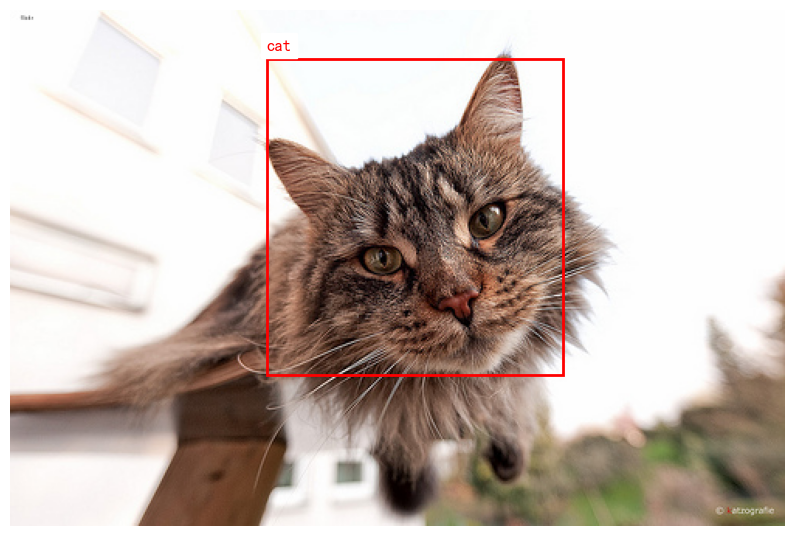

In [60]:
# 假设有一个已经加载好的数据集
label_map_reverse = {0: "cat", 1: "dog"}  # 类别编号到类别名的映射
image, target = dataset[50]  # 从数据集中获取第一个样本
visualize_image(image, target, label_map_reverse)

In [63]:
# import os
# import xml.etree.ElementTree as ET

# def convert_voc_to_txt(xml_folder, output_folder, label_map):
#     """
#     将 VOC 格式 XML 文件中的边界框坐标提取并保存为 .txt 文件。

#     Args:
#         xml_folder (str): 输入 XML 文件夹路径。
#         output_folder (str): 输出 .txt 文件夹路径。
#     """
#     # 确保输出文件夹存在
#     os.makedirs(output_folder, exist_ok=True)

#     # 遍历 XML 文件夹
#     for xml_file in os.listdir(xml_folder):
#         if not xml_file.endswith(".xml"):
#             continue
        
#         # 解析 XML 文件
#         xml_path = os.path.join(xml_folder, xml_file)
#         tree = ET.parse(xml_path)
#         root = tree.getroot()
        
#         # 提取文件名（不含扩展名）
#         file_name = os.path.splitext(xml_file)[0]
        
#         # 打开目标 .txt 文件
#         txt_path = os.path.join(output_folder, f"{file_name}.txt")
#         with open(txt_path, "w") as f:
#             # 遍历目标对象
#             for obj in root.findall("object"):
#                 bndbox = obj.find("bndbox")
#                 name = obj.find("name").text
#                 if name not in label_map:
#                     continue  # 跳过未定义的类别
#                 # 获取标签编号
#                 label = label_map[name]
#                 xmin = int(bndbox.find("xmin").text)
#                 ymin = int(bndbox.find("ymin").text)
#                 xmax = int(bndbox.find("xmax").text)
#                 ymax = int(bndbox.find("ymax").text)
                
#                 # 保存为格式化字符串
#                 f.write(f"{label} {xmin} {ymin} {xmax} {ymax}\n")
        
#         print(f"Processed: {xml_file} -> {txt_path}")

# # 示例用法
# xml_folder = "../../../../../data/02.cv/dog-and-cat-detection/annotations_xml/"  # 替换为你的 XML 文件夹路径
# output_folder = "../../../../../data/02.cv/dog-and-cat-detection/annotations_txt/"  # 替换为输出文件夹路径
# label_map = {"cat": 0, "dog": 1} 

# convert_voc_to_txt(xml_folder, output_folder, label_map)

### 自定义数据集

将图片和标签文件分为 train、val 和 test 集合，并按格式存储，同时对标签文件进行归一化。

In [5]:
# import os
# import shutil
# from sklearn.model_selection import train_test_split
# from PIL import Image

# def organize_dataset(images_folder, labels_folder, output_folder, train_ratio=0.7, val_ratio=0.2):
#     """
#     将图片和标签文件分为 train、val 和 test 集合，并按格式存储，同时对标签文件进行归一化。

#     Args:
#         images_folder (str): 图片文件夹路径。
#         labels_folder (str): 标签文件夹路径。
#         output_folder (str): 输出数据集根目录。
#         train_ratio (float): 训练集比例。
#         val_ratio (float): 验证集比例。
#     """
#     # 创建输出目录
#     image_output = os.path.join(output_folder, "images")
#     label_output = os.path.join(output_folder, "labels")
#     for split in ["train", "val", "test"]:
#         os.makedirs(os.path.join(image_output, split), exist_ok=True)
#         os.makedirs(os.path.join(label_output, split), exist_ok=True)

#     # 获取所有图片和标签文件
#     images = sorted([f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.png'))])
#     labels = sorted([f for f in os.listdir(labels_folder) if f.endswith(".txt")])

#     # 确保图片和标签文件匹配
#     images = [img for img in images if os.path.splitext(img)[0] + ".txt" in labels]
#     labels = [lbl for lbl in labels if os.path.splitext(lbl)[0] + ".png" in images]

#     # 分割数据集
#     train_images, temp_images, train_labels, temp_labels = train_test_split(
#         images, labels, test_size=(1 - train_ratio), random_state=42
#     )
#     val_images, test_images, val_labels, test_labels = train_test_split(
#         temp_images, temp_labels, test_size=(1 - val_ratio / (1 - train_ratio)), random_state=42
#     )

#     # 定义一个函数归一化标签
#     def normalize_label(label_path, image_path, output_path):
#         try:
#             with Image.open(image_path) as img:
#                 img_width, img_height = img.size

#             normalized_lines = []
#             with open(label_path, "r") as f:
#                 for line in f:
#                     parts = line.strip().split()
#                     if len(parts) < 5:
#                         print(f"Skipping invalid line in {label_path}: {line}")
#                         continue
#                     class_id, x_min, y_min, x_max, y_max = map(float, parts[:5])
#                     x_center = (x_min + x_max) / 2 / img_width
#                     y_center = (y_min + y_max) / 2 / img_height
#                     width = (x_max - x_min) / img_width
#                     height = (y_max - y_min) / img_height

#                     if all(0 <= v <= 1 for v in [x_center, y_center, width, height]):
#                         normalized_lines.append(f"{int(class_id)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
#                     else:
#                         print(f"Skipping out-of-bounds line in {label_path}: {line}")

#             if normalized_lines:
#                 with open(output_path, "w") as f:
#                     f.write("\n".join(normalized_lines))
#             else:
#                 print(f"No valid lines in {label_path}. Skipping.")
#         except Exception as e:
#             print(f"Error processing {label_path} with {image_path}: {e}")

#     # 定义一个函数拷贝和处理文件
#     def copy_and_normalize(files, src_folder, dst_folder, is_label=False):
#         for file in files:
#             src_path = os.path.join(src_folder, file)
#             dst_path = os.path.join(dst_folder, file)
#             if is_label:
#                 image_path = os.path.join(images_folder, file.replace(".txt", ".png"))
#                 normalize_label(src_path, image_path, dst_path)
#             else:
#                 shutil.copy(src_path, dst_path)

#     # 拷贝图片和标签到相应目录
#     copy_and_normalize(train_images, images_folder, os.path.join(image_output, "train"))
#     copy_and_normalize(train_labels, labels_folder, os.path.join(label_output, "train"), is_label=True)

#     copy_and_normalize(val_images, images_folder, os.path.join(image_output, "val"))
#     copy_and_normalize(val_labels, labels_folder, os.path.join(label_output, "val"), is_label=True)

#     copy_and_normalize(test_images, images_folder, os.path.join(image_output, "test"))
#     copy_and_normalize(test_labels, labels_folder, os.path.join(label_output, "test"), is_label=True)

#     print(f"Dataset organized successfully in {output_folder}!")

#     # 生成 data.yaml 文件
#     yaml_content = f"""
# path: {output_folder}
# train: {os.path.join("images/", 'train')}
# val: {os.path.join("images/", 'val')}
# test: {os.path.join("images/", 'test')}

# nc: 2  
# names: ['cat', 'dog']  
#     """
#     with open(os.path.join(output_folder, "data.yaml"), "w") as f:
#         f.write(yaml_content.strip())
#     print(f"data.yaml file created at {os.path.join(output_folder, 'data.yaml')}")

# # 示例用法
# images_folder = "../../../../../data/02.cv/dog-and-cat-detection/images" # 替换为你的图片文件夹路径
# labels_folder = "../../../../../data/02.cv/dog-and-cat-detection/annotations_txt"       # 替换为你的标签文件夹路径
# output_folder = "../../../../../data/02.cv/dog_cat_detection"     # 替换为输出文件夹路径

# organize_dataset(images_folder, labels_folder, output_folder)

## 模型训练

yolo11n.yaml是yolo11的配置，yolo11n.pt是预训练的模型.

### 预训练模型

在训练完成后，YOLO 模型的权重文件通常会自动保存到项目目录下的 runs/train/ 目录中，具体路径取决于训练的实验名称（如 runs/detect/train/weights/best.pt）。

In [7]:
model = YOLO("yolo11n.pt") # 如果本地没有会从官网下载模型权重
model.train(data="D:/Jupyter notebook/data/02.cv/dog_cat_detection/data.yaml", epochs=5, batch=16, device='cuda')
model.val(data="D:/Jupyter notebook/data/02.cv/dog_cat_detection/data.yaml")

WARNING Download failure, retrying 1/3 https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11n.pt...
WARNING Download failure, retrying 2/3 https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11n.pt...
Ultralytics 8.3.113  Python-3.12.7 torch-2.8.0.dev20250414+cu128 CUDA:0 (NVIDIA GeForce RTX 5090 Laptop GPU, 24463MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=D:/Jupyter notebook/data/02.cv/dog_cat_detection/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, pl

100.0%

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

YOLO11n summary: 181 layers, 2,590,230 parameters, 2,590,214 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed 
train: Fast image access  (ping: 0.30.1 ms, read: 54.138.4 MB/s, size: 241.7 KB)


train: Scanning D:\Jupyter notebook\data\02.cv\dog_cat_detection\labels\train.cache... 2580 images, 0 backgrounds, 0 co


val: Fast image access  (ping: 0.20.0 ms, read: 27.113.4 MB/s, size: 184.9 KB)


val: Scanning D:\Jupyter notebook\data\02.cv\dog_cat_detection\labels\val.cache... 737 images, 0 backgrounds, 0 corrupt


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.25G      1.011      2.138      1.325          8        640: 100%|██████████| 162/162 [00:16<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:03

                   all        737        737       0.79      0.694      0.774      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.64G      1.025       1.42      1.291          7        640: 100%|██████████| 162/162 [00:14<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02


                   all        737        737      0.532      0.654      0.679       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.64G      1.027      1.181      1.283          6        640: 100%|██████████| 162/162 [00:13<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        737        737      0.821      0.792      0.861      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.64G     0.9398     0.9657      1.227          9        640: 100%|██████████| 162/162 [00:13<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        737        737      0.917      0.905      0.964      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.64G     0.8332     0.8063      1.168          7        640: 100%|██████████| 162/162 [00:13<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        737        737      0.976      0.959      0.991      0.829



5 epochs completed in 0.024 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 5.4MB
Optimizer stripped from runs\detect\train\weights\best.pt, 5.4MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.113  Python-3.12.7 torch-2.8.0.dev20250414+cu128 CUDA:0 (NVIDIA GeForce RTX 5090 Laptop GPU, 24463MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02


                   all        737        737      0.976      0.959      0.991      0.829
                   cat        252        252      0.976      0.965      0.992      0.871
                   dog        485        485      0.976      0.953       0.99      0.787
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect\train
Ultralytics 8.3.113  Python-3.12.7 torch-2.8.0.dev20250414+cu128 CUDA:0 (NVIDIA GeForce RTX 5090 Laptop GPU, 24463MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 3648.51266.1 MB/s, size: 296.7 KB)


val: Scanning D:\Jupyter notebook\data\02.cv\dog_cat_detection\labels\val.cache... 737 images, 0 backgrounds, 0 corrupt
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:03


                   all        737        737      0.969      0.967      0.989      0.829
                   cat        252        252      0.972      0.972      0.988      0.872
                   dog        485        485      0.965      0.962       0.99      0.786
Speed: 0.2ms preprocess, 1.6ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000288DD561730>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

### 自定义模型

如果我们想要训练自己的模型的话，需要修改一下配置文件，首先到[GitHub](https://github.com/ultralytics/ultralytics?tab=readme-ov-file)上下载yolo11n.yaml。然后修改yolo11n.yaml，把nc的数值改成你的数据集的类别数。但自定义模型一般训练结果都不好。

In [2]:
model = YOLO("yolo11n.yaml")  # 从头构建模型
model.train(data="D:/Jupyter notebook/data/02.cv/dog_cat_detection/data.yaml", epochs=5, batch=16, device='cuda')
model.val(data="D:/Jupyter notebook/data/02.cv/dog_cat_detection/data.yaml")

Ultralytics 8.3.54  Python-3.9.18 torch-2.0.0+cu118 CUDA:0 (NVIDIA GeForce MX350, 2048MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.yaml, data=D:/Jupyter notebook/data/02.cv/dog_cat_detection/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, sh

100%|█████████████████████████████████████████████████████████████████████████████| 5.35M/5.35M [00:05<00:00, 1.07MB/s]


AMP: checks passed 


train: Scanning D:\Jupyter notebook\data\02.cv\dog_cat_detection\labels\train.cache... 2580 images, 0 backgrounds, 0 co
val: Scanning D:\Jupyter notebook\data\02.cv\dog_cat_detection\labels\val.cache... 737 images, 0 backgrounds, 0 corrupt


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.62G      2.854      4.189      3.971          8        640: 100%|██████████| 162/162 [14:47<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:05

                   all        737        737    0.00286      0.669    0.00614    0.00168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.68G      2.658      3.544      3.216          7        640: 100%|██████████| 162/162 [18:24<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:18


                   all        737        737      0.219       0.13      0.118     0.0422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.67G      2.375      2.966      2.862          6        640: 100%|██████████| 162/162 [15:41<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:50


                   all        737        737      0.266      0.333      0.244     0.0878

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.68G      2.087      2.579      2.588          9        640: 100%|██████████| 162/162 [14:02<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:50

                   all        737        737      0.453       0.47      0.436      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.67G        1.9      2.286      2.362          7        640: 100%|██████████| 162/162 [13:26<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:45

                   all        737        737      0.502      0.581      0.556      0.293



5 epochs completed in 1.355 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 5.4MB
Optimizer stripped from runs\detect\train\weights\best.pt, 5.4MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.54  Python-3.9.18 torch-2.0.0+cu118 CUDA:0 (NVIDIA GeForce MX350, 2048MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12


                   all        737        737      0.502      0.581      0.556      0.293
                   cat        252        252      0.531       0.44       0.51      0.299
                   dog        485        485      0.473      0.722      0.602      0.286
Speed: 0.6ms preprocess, 11.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\train
Ultralytics 8.3.54  Python-3.9.18 torch-2.0.0+cu118 CUDA:0 (NVIDIA GeForce MX350, 2048MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning D:\Jupyter notebook\data\02.cv\dog_cat_detection\labels\val.cache... 737 images, 0 backgrounds, 0 corrupt
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:13


                   all        737        737      0.503      0.579      0.556      0.292
                   cat        252        252      0.533       0.44      0.511      0.299
                   dog        485        485      0.472      0.718      0.601      0.286
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs\detect\train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000238B2FBEFD0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

## 模型预测

### 预测单张图

In [8]:
# 加载最佳权重
trained_model = YOLO("../outputs/best_models/YOLO/runs/detect/train/weights/best.pt")

In [9]:
img = cv2.imread("../data/cats_and_dogs_small/train/cats/cat.2.jpg")
results = trained_model.predict(source=img, save=True, save_txt=True, device='cuda') 


0: 640x512 1 cat, 25.1ms
Speed: 7.9ms preprocess, 25.1ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 512)
Results saved to runs\detect\predict
1 label saved to runs\detect\predict\labels


In [10]:
# 查看预测的类别标签、置信度和边界框坐标
for result in results:
    # 获取预测框的类别索引
    print("Classes:", result.boxes.cls)  # 类别索引列表
    # 获取类别名称，通常会根据data.yaml中的类别映射
    print("Class Names:", result.names)  # 类别名称
    # 获取预测框的置信度
    print("Confidences:", result.boxes.conf)  # 每个框的置信度
    # 获取预测框的坐标 (xmin, ymin, xmax, ymax)
    print("Boxes:", result.boxes.xyxy)  # 边界框坐标

Classes: tensor([0.], device='cuda:0')
Class Names: {0: 'cat', 1: 'dog'}
Confidences: tensor([0.8780], device='cuda:0')
Boxes: tensor([[ 30.2281,   7.8142, 202.8399, 205.3990]], device='cuda:0')


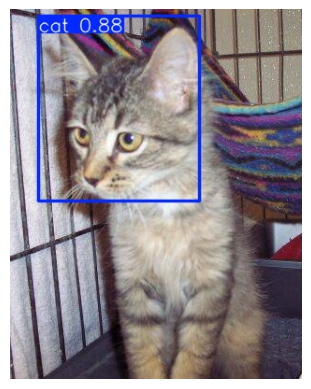

In [15]:
# 查看结果
image = Image.open("../outputs/best_models/YOLO/runs/detect/predict/cat.2.jpg")
# 显示图像
plt.imshow(image)
plt.axis("off")  # 隐藏坐标轴
plt.show()

在预测的图像上，标注框旁边的文字（例如 cat 0.88）表示以下含义：

- cat：表示模型预测的类别，这里是“猫”。
- 0.88：表示模型对该类别的置信度（Confidence Score），范围是 [0, 1]，表示模型对这个预测的“确信程度”。
    - 置信度越接近 1，说明模型越有信心认为该目标是 cat。
    - 如果置信度较低（如 0.3 或以下），则可能是错误检测或模型不够确信。

### 预测多张图

In [12]:
img_path = "../data/cats_and_dogs_small/train/cats/"
results = trained_model.predict(source=img_path, save=True, save_txt=True, device='cuda') 


image 1/1000 D:\Jupyter notebook\src\01.python\04.application\05.cv\src\..\data\cats_and_dogs_small\train\cats\cat.0.jpg: 480x640 1 cat, 24.4ms
image 2/1000 D:\Jupyter notebook\src\01.python\04.application\05.cv\src\..\data\cats_and_dogs_small\train\cats\cat.1.jpg: 608x640 1 cat, 37.6ms
image 3/1000 D:\Jupyter notebook\src\01.python\04.application\05.cv\src\..\data\cats_and_dogs_small\train\cats\cat.10.jpg: 640x640 1 cat, 18.4ms
image 4/1000 D:\Jupyter notebook\src\01.python\04.application\05.cv\src\..\data\cats_and_dogs_small\train\cats\cat.100.jpg: 640x544 1 cat, 35.5ms
image 5/1000 D:\Jupyter notebook\src\01.python\04.application\05.cv\src\..\data\cats_and_dogs_small\train\cats\cat.101.jpg: 448x640 1 cat, 1 dog, 23.9ms
image 6/1000 D:\Jupyter notebook\src\01.python\04.application\05.cv\src\..\data\cats_and_dogs_small\train\cats\cat.102.jpg: 640x640 1 cat, 8.1ms
image 7/1000 D:\Jupyter notebook\src\01.python\04.application\05.cv\src\..\data\cats_and_dogs_small\train\cats\cat.103.jpg

In [13]:
# 查看结果
image = Image.open("../outputs/best_models/YOLO/runs/detect/predict/cat.100.jpg")
# 显示图像
plt.imshow(image)
# plt.axis("off")  # 隐藏坐标轴
plt.show()

<Figure size 640x480 with 1 Axes>

## 模型部署

In [26]:
# 导出为 ONNX 格式
trained_model.export(format="onnx", dynamic=True)  # dynamic=True 表示支持动态输入尺寸

Ultralytics 8.3.53  Python-3.9.18 torch-2.0.0+cu118 CPU (Intel Core(TM) i7-10510U 1.80GHz)

PyTorch: starting from '..\outputs\best_models\YOLO\runs\detect\train\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (5.2 MB)

ONNX: starting export with onnx 1.17.0 opset 17...
============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

ONNX: slimming with onnxslim 0.1.45...
ONNX: export success  20.7s, saved as '..\outputs\best_models\YOLO\runs\detect\train\weights\best.onnx' (10.0 MB)

Export complete (21.4s)
Results saved to D:\Jupyter notebook\src\01.python\04.application\05.cv\outputs\best_models\YOLO\runs\detect\train\weights
Predict:         yolo predict task=detect model=..\outputs\best_models\YOLO\runs\detect\train\weights\best.onnx imgsz=640  
Validate:        yolo val task=detect model=..\outputs\best_m

'..\\outputs\\best_models\\YOLO\\runs\\detect\\train\\weights\\best.onnx'

## ONNX推理

In [27]:
import onnxruntime as ort
import numpy as np
from PIL import Image

# 加载 ONNX 模型
onnx_model_path = "../outputs/best_models/YOLO/runs/detect/train/weights/best.onnx"
session = ort.InferenceSession(onnx_model_path)

# 检查模型的输入和输出
print("Inputs:", session.get_inputs())
print("Outputs:", session.get_outputs())

# 准备输入数据（调整图像大小并归一化）
image = Image.open("../data/cats_and_dogs_small/train/cats/cat.2.jpg").convert("RGB")
image = image.resize((640, 640))  # YOLO 模型通常使用 640x640 的输入
input_data = np.array(image, dtype=np.float32) / 255.0  # 归一化到 [0, 1]
input_data = np.transpose(input_data, (2, 0, 1))  # HWC -> CHW
input_data = np.expand_dims(input_data, axis=0)  # 添加 batch 维度

# 推理
input_name = session.get_inputs()[0].name
outputs = session.run(None, {input_name: input_data})

# 输出结果
print("Model Outputs:", outputs)

Inputs: [<onnxruntime.capi.onnxruntime_pybind11_state.NodeArg object at 0x0000017410D2BEF0>]
Outputs: [<onnxruntime.capi.onnxruntime_pybind11_state.NodeArg object at 0x0000017410D2B3F0>]
Model Outputs: [array([[[     31.591,      30.348,      27.204, ...,      537.64,      587.61,      590.04],
        [     18.754,      7.3549,      8.4524, ...,      568.81,      560.77,      561.65],
        [     108.18,      127.52,      129.96, ...,      204.97,      106.09,      100.13],
        [     42.216,      15.418,      16.895, ...,      143.06,      158.92,      157.75],
        [ 3.7134e-05,  5.8055e-05,    4.22e-05, ...,  0.00061479,  0.00068757,  0.00057763],
        [ 4.5866e-05,  7.9781e-05,  6.0797e-05, ...,  0.00049835,  0.00063014,  0.00088614]]], dtype=float32)]


In [32]:
predictions = outputs[0]  # 获取第一个输出
image = cv2.imread("../data/cats_and_dogs_small/train/cats/cat.2.jpg")
for prediction in predictions[0]:
    confidence = prediction[4]
    class_probs = prediction[5:]

    # 获取置信度最高的类别及其概率
    class_id = np.argmax(class_probs)
    class_confidence = class_probs[class_id]
    
    if confidence > 0.5 and class_confidence > 0.5:
        x, y, w, h = prediction[:4]
        x_min, y_min = int(x - w / 2), int(y - h / 2)
        x_max, y_max = int(x + w / 2), int(y + h / 2)
        class_id = np.argmax(class_probs)

        # 绘制边界框和标签
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        label = f"Class {class_id}: {class_confidence:.2f}"
        cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

cv2.imshow("Predictions", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 基于Fast R-CNN的目标检测算法

## 模型定义

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50
from torchvision.ops import roi_pool

class FastRCNN(nn.Module):
    def __init__(self, num_classes, backbone='resnet50'):
        super(FastRCNN, self).__init__()
        
        # 主干网络：特征提取器
        if backbone == 'resnet50':
            base_model = resnet50(pretrained=True)  # 使用预训练的 ResNet-50
            self.feature_extractor = nn.Sequential(*list(base_model.children())[:-2])  # 去除全连接层和平均池化层
            feature_dim = 2048  # ResNet-50 的特征通道数
        
        # RoI 池化层
        self.roi_pool = roi_pool
        
        # 分类和回归的全连接层
        self.fc = nn.Sequential(
            nn.Linear(feature_dim * 7 * 7, 1024),  # 输入为展平后的 RoI 特征
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU()
        )
        
        # 分类输出层和边界框回归输出层
        self.cls_score = nn.Linear(1024, num_classes)  # 分类层
        self.bbox_pred = nn.Linear(1024, num_classes * 4)  # 边界框回归层
    
    def forward(self, images, rois):
        """
        Fast R-CNN 的前向传播。
        
        参数:
            images: Tensor, 形状为 (B, C, H, W)，输入图像。
            rois: Tensor, 形状为 (N, 5)，每一行是 [batch_idx, x1, y1, x2, y2]。
        
        返回:
            cls_scores: 每个 RoI 的分类分数。
            bbox_preds: 每个 RoI 的边界框预测。
        """
        # 第一步：提取特征图
        feature_maps = self.feature_extractor(images)
        
        # 第二步：RoI 池化
        pooled_features = self.roi_pool(feature_maps, rois, output_size=(7, 7))  # RoI 池化后的特征
        pooled_features = pooled_features.view(pooled_features.size(0), -1)  # 展平为全连接层的输入
        
        # 第三步：通过全连接层
        fc_features = self.fc(pooled_features)
        
        # 第四步：计算分类分数和边界框回归结果
        cls_scores = self.cls_score(fc_features)  # 分类分数
        bbox_preds = self.bbox_pred(fc_features)  # 边界框回归结果
        
        return cls_scores, bbox_preds